In [1]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from einops.layers.torch import Rearrange
import torch
import torchvision
import scipy

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/home/razvan/data/adni_preprocessed_v4/train_annot.csv")

LABELS_MAPPING = {
    'CN': 0, # Cognitively Normal
    'SMC': 1, # Significant Memory Concern
    'MCI': 2, # Mild Cognitive Impairment
    'LMCI': 3, # Late Mild Cognitive Impairment 
    'EMCI': 4, # Early Mild Cognitive Impairment
    'AD': 5, # Alzheimer's Dementia
}

INV_LABELS_MAPPING = {v: k for k, v in LABELS_MAPPING.items()}

df["label"] = df["label"].apply(lambda x: INV_LABELS_MAPPING[x])
df.to_csv("/home/razvan/data/adni_preprocessed_v4/val_annot_explicit.csv")

label
CN      1127
EMCI     610
MCI      445
LMCI     376
AD       274
SMC      131
Name: count, dtype: int64


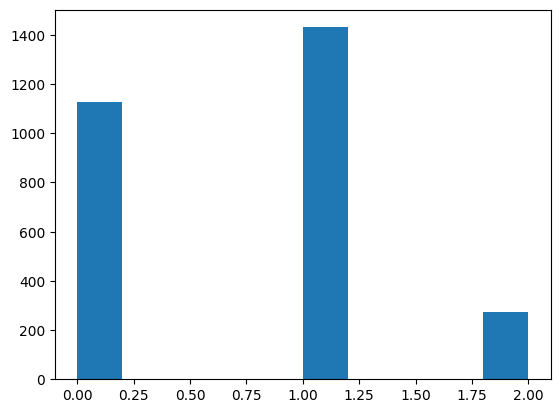

[0.65967855 0.83762201 3.44525547]


In [29]:
from sklearn.utils.class_weight import compute_class_weight

df = pd.read_csv("/home/razvan/data/adni_preprocessed_v4/train_annot.csv")
print(df["label"].value_counts())
labels_mapping = {
    "CN": 0, 
    "SMC": -1, 
    "MCI": 1, 
    "LMCI": 1, 
    "EMCI": 1, 
    "AD": 2
}
labels = df["label"].apply(lambda x: labels_mapping[x])
labels = labels[labels != -1]
plt.hist(labels)
plt.show()

class_weight = compute_class_weight(class_weight="balanced", classes=labels.unique(), y=labels)
print(class_weight)

In [ ]:
import copy

def normalize_frame(frame):
    """Normalize the frame data to 0-255."""
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
    return frame.astype(np.uint8)

# Load the image
path = "/home/razvan/data/adni_preprocessed_v3/train_img"
dest_folder = "/home/razvan/data/movies"
files = os.listdir(path)
for file in files:
    file_dest_folder = os.path.join(dest_folder, file)
    img = nib.load(os.path.join(path, file))
    data = img.get_fdata()
    x_dim, y_dim, z_dim, time_stamps = data.shape

    frame_size = 256
    frame_size = frame_size if frame_size % 2 == 0 else frame_size - 1  

    num_cols = int(np.ceil(np.sqrt(time_stamps)))
    num_rows = int(np.ceil(time_stamps / num_cols))

    os.makedirs(file_dest_folder, exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    for slice_index in range(z_dim):
        video_path = os.path.join(file_dest_folder, f"slice_{slice_index}.mp4")
        out = cv2.VideoWriter(video_path, fourcc, 10, (frame_size, frame_size), isColor=True)

        for temp_index in range(time_stamps):
            frame = data[:, :, slice_index, temp_index]
            frame = normalize_frame(frame)

            rot_frame = np.rot90(frame)
            resized_frame = cv2.resize(rot_frame, (frame_size, frame_size))
            
            # Convert grayscale to BGR explicitly
            color_frame = cv2.cvtColor(resized_frame, cv2.COLOR_GRAY2BGR)
            
            out.write(color_frame)  # Ensure frames are written

        out.release()

print("All videos saved successfully.")

KeyboardInterrupt: 